# Make anaphase time predictions based on the instataneous surface only

First attempt to predict the anaphase time based on the time series of the relative surface feature only. We will use simple simple machine learning algorithms to make our predictions as a first attempt. Here we use univariate linear regression as a model.

Problem formulation $\forall$ division event $i$, $\forall 0< t < t^*$, we want to predict the target variable $y_{i, t} = t_i^* - t$ , the relative time to anaphase(TTA), based on the present feature, $X_{i, t}$ ; i.e. we want $$f : X_{i, t} \mapsto y_{i, t} = t_i^* - t \in \mathbb{R_+^*}$$

This is regression problem, and we will use the classical MSE as a loss function/evaluation metrics.

In [153]:
%matplotlib inline
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks
import sklearn

import napari

sns.set_theme()

## Loading Data

In [177]:
os.chdir("D:/Hugo/Anaphase")
data = pd.read_csv("Analysis_BF_f0001-1-100.2.csv", sep=",", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0].dropna()

# don't take the extremely long division processes into account 
data = data.drop(data[data.time_to_anaphase > 50].index)

print(data.shape)
data.head()

(475, 25)


,mom_ID,daugh_ID,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,...,daugh_ecc,mom_circ,daugh_circ,inter_centroid_dist,relat_inter_centroid_distance,anaphase,time_to_anaphase,movie_name,relat_circ,relat_ecc
idx,,,,,,,,,,,,,,,,,,,,,
0,7.0,5.0,0,0,341.034087,228.261538,332.043137,219.000000,178.867772,0.093045,...,0.992654,0.855372,0.785398,12.041595,0.343205,False,30,BF_f0001,0.918195,1.236316
0,7.0,5.0,1,6,341.018145,228.611940,330.688627,219.560000,186.583478,22.828404,...,0.898987,0.845002,0.857435,13.453624,0.287268,False,24,BF_f0001,1.014713,1.126581
0,7.0,5.0,2,12,337.864857,229.230769,326.733809,220.484848,177.583462,41.406857,...,0.937833,0.830149,0.864472,14.212670,0.284953,False,18,BF_f0001,1.041346,1.185947
0,7.0,5.0,3,18,338.649472,229.276923,326.261941,220.538462,177.867772,60.269635,...,0.875355,0.850590,0.878475,15.000000,0.279812,False,12,BF_f0001,1.032783,1.106011
0,7.0,5.0,4,24,339.320884,229.285714,326.185018,220.589744,172.867787,68.416707,...,0.859748,0.854060,0.887776,15.000000,0.273308,False,6,BF_f0001,1.039477,1.108345


## 0. Static baseline : always predicting the mean TTA observed on the training set

Here we compute the performances of a naive baseline, that always makes the same prediction, which corresponds to the mean anaphase time observed on the training set. More precisely, the model only looks at the elapsed time since the bud detection and will predict, at each instant $t$, $TTA = \bar{t}^*_{train} - t$.

The rmse for those predictions should be the conditional variance of the data, given that the anaphase is occuring: $Var(TTA_t | anaphase(t))$

The naive static baseline is not so bad, this puts into perspective the performances of other models, which are not so much better after all.

In [178]:
from sklearn.model_selection import train_test_split

k_fold, rmses = 10, []

for k in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(data["time"], data["time_to_anaphase"], train_size=0.75)
    
    MEAN_DIVISION_TIME = X_train[y_train == 0].mean() # here we consider that the division time is the same for each trajectory
    
    y_pred = (MEAN_DIVISION_TIME - X_test) # always predict the same time
    
    rmses.append(np.sqrt(((y_test - y_pred) ** 2).mean()))
    
rmses = np.array(rmses)

print(rmses)
print(f"Mean RMSE on {k_fold}-fold CV : {round(rmses.mean(), 2)} +- {round(rmses.std(), 2)} min.")

[6.73768577 7.23771053 8.11290903 7.70977634 7.98098841 8.26170208
 7.41474655 7.905986   8.00367563 7.8894675 ]
Mean RMSE on 10-fold CV : 7.73 +- 0.44 min.


## 1. Linear regression on the relative surface : $TTA_t = \beta RS_t + \epsilon_t$

Here we will try to fit a linear regression to predict the TTA given the cumulative relative surface at time $t$. This is a dumb regressor, as it will not be bad on average, but learns to predict from single data points (i.e. makes the assumption that all the observations are i.i.d.) instead of taking the cell's history into account and trying to predict, at each time step of a time series, the TTA. As we will see, it will not perform bad on average (RMSE of 5 minutes) and will simply make early predictions on the points that are over the curve (latecomers) and late observations on the points which are under the curve (earlycomers). 

### 1.1 Training

In [193]:
# prepare the training set
from sklearn.model_selection import train_test_split

features = "relat_per"

data = data[data[features] > 0]

# data[features] = (data[features] - data[features].mean()) / data[features].std() # dataset-wise standardization
for idx, traj in data.groupby(level=0):
    traj_mean, traj_std = traj[features].mean(), traj[features].std()
    
    for t in traj.time:
        data[(data["time"] == t)].loc[idx][features] = (traj[traj["time"] == t][features] - traj_mean) / traj_std

X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["time_to_anaphase"], train_size=0.6)
X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(417, 1) (279, 1) (417,) (279,)


In [194]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(X_train, y_train)

print(f"R^2 coefficient : {round(lm.score(X_train, y_train), 2)}")

# predictions on train set
predictions_on_train_set = lm.predict(X_train)

plot = False
if plot:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X_train, y_train, c='b', label="Train set")
    ax.plot(X_train, predictions_on_train_set, c="r", label="Predictions")
    ax.set_xlabel(features)
    ax.set_ylabel("TTA (min)")
    ax.set_title("Linear regression predictions on the training set")
    
print(f"Regression equation : {lm.coef_[0]} * daughter_surface + {lm.intercept_}")

R^2 coefficient : 0.64
Regression equation : -53.9690270635277 * daughter_surface + 41.46137297516057


### 1.2 Evaluation

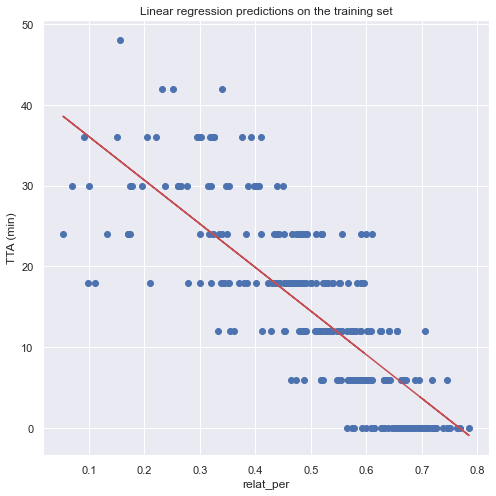

In [195]:
predictions_on_test_set = lm.predict(X_test)

plot = True
if plot:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X_test, y_test, c='b', label="Test set")
    ax.plot(X_test, predictions_on_test_set, c="r", label="Predictions")
    ax.set_xlabel(features)
    ax.set_ylabel("TTA (min)")
    ax.set_title("Linear regression predictions on the training set")
    plt.savefig("Linear Regression", format="pdf")

RMSE : 6.541411910444778


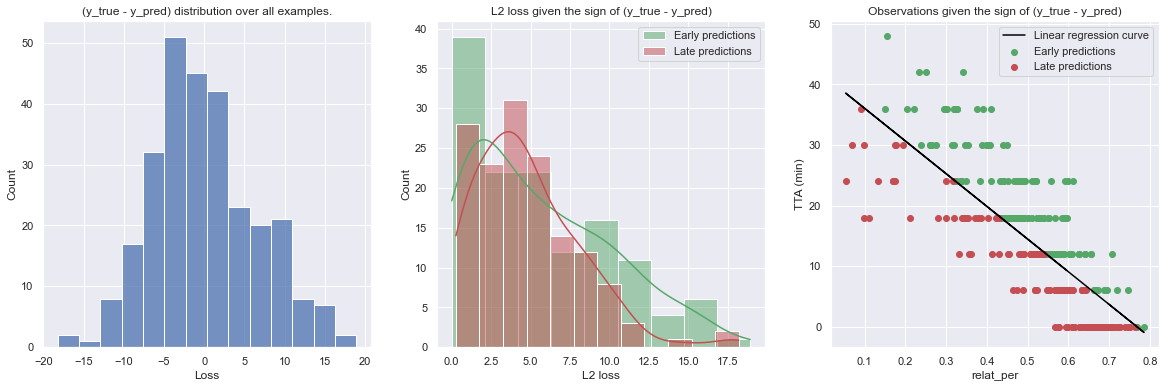

In [196]:
# evaluation with the clasical RMSE
signed_losses = (y_test - predictions_on_test_set) 
losses = signed_losses ** 2
print(f"RMSE : {np.sqrt(losses.mean())}")

plot = True
if plot:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # RMSE distribution
    sns.histplot(signed_losses, ax=axes[0])
    axes[0].set_title("(y_true - y_pred) distribution over all examples.")
    axes[0].set_xlabel("Loss")

    # Conditional distributions given the sign of the error
    sns.histplot(np.sqrt(losses[signed_losses >= 0]), color="g", kde=True, label="Early predictions", ax=axes[1])
    sns.histplot(np.sqrt(losses[signed_losses < 0]), color="r", kde=True, label="Late predictions", ax=axes[1])
    axes[1].legend()
    axes[1].set_xlabel("L2 loss")
    axes[1].set_title("L2 loss given the sign of (y_true - y_pred)")

    # conditional distributions of the points
    axes[2].scatter(X_test[signed_losses >= 0], y_test[signed_losses >= 0], c="g", label="Early predictions")
    axes[2].scatter(X_test[signed_losses < 0], y_test[signed_losses < 0], c="r", label="Late predictions")
    axes[2].plot(X_test, predictions_on_test_set, c="black", label="Linear regression curve")
    axes[2].legend()
    axes[2].set_xlabel(features)
    axes[2].set_ylabel("TTA (min)")
    axes[2].set_title("Observations given the sign of (y_true - y_pred)")
    plt.savefig("Linear Reg errors", format="pdf")

### 1.3 Cross validation (k-Fold validation)

In [198]:
from sklearn.model_selection import KFold

features = "relat_per"

X, y = data[features].values.reshape(-1, 1), data["time_to_anaphase"].values.reshape(-1, 1)
n_iter = 10
kf = KFold(n_splits=n_iter)

rmse, scores = [], []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    lm = LinearRegression().fit(X_train, y_train)
    scores.append(lm.score(X_test, y_test))
    rmse.append(np.sqrt(((y_test - lm.predict(X_test)) ** 2).mean()))
rmse = np.array(rmse)
scores = np.array(scores)

print(f"R^2 on {n_iter} folds : {scores}")
print(f"Mean R^2 on {n_iter}-fold cross-validation : {round(scores.mean(), 2)} +- {round(scores.std(), 2)}.\n")

print(f"RMSE on {n_iter} folds : {scores}")
print(f"Mean RMSE on {n_iter}-fold cross-validation : {round(rmse.mean(), 2)}  +- {round(rmse.std(), 2)} min.")

R^2 on 10 folds : [0.57068682 0.60264788 0.65959132 0.71343833 0.58097949 0.78541357
 0.4380456  0.56354037 0.67811148 0.7295739 ]
Mean R^2 on 10-fold cross-validation : 0.63 +- 0.1.

RMSE on 10 folds : [0.57068682 0.60264788 0.65959132 0.71343833 0.58097949 0.78541357
 0.4380456  0.56354037 0.67811148 0.7295739 ]
Mean RMSE on 10-fold cross-validation : 6.6  +- 0.96 min.


### 1.4 Diagnostic plots

No handles with labels found to put in legend.
<ipython-input-184-26dca92f6fe1>:31: RuntimeWarning: Mean of empty slice.
  means.append(np.array(predictions_here).mean())
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Autocorrelogram of residuals')

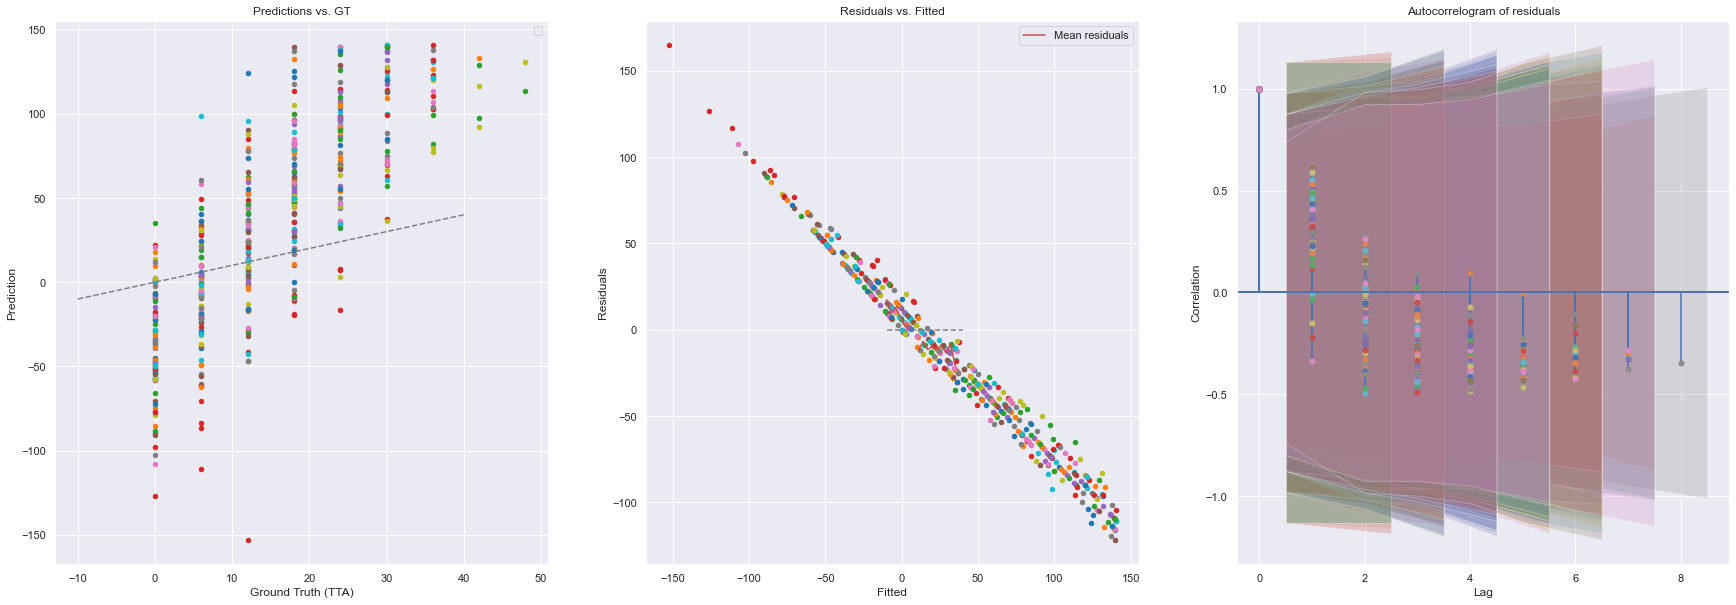

In [184]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

import matplotlib.colors as mcolors
by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.TABLEAU_COLORS.items()]
names = [name for hsv, name in by_hsv]

predictions = lm.predict((data[features].values.reshape(-1, 1) - data[features].values.mean()) / data[features].values.std())

# Predictions vs. GT
for p, gt, idx in zip(predictions, data["time_to_anaphase"], data.index):
    if idx < 100:
        ax[0].plot(gt, p, ".", c=names[idx % len(names)], ms=9)
ax[0].plot([-10, 40], [-10, 40], "--", c="grey")
ax[0].legend()

ax[0].set_xlabel("Ground Truth (TTA)")
ax[0].set_ylabel("Prediction")
ax[0].set_title("Predictions vs. GT")

# Residuals vs. Fitted
means = []
intervals = np.arange(-10, 40, 3)
for k in intervals:
    predictions_here = []
    for p, gt in zip(predictions, data["time_to_anaphase"].values):
        if k <= p and p  < k+1:
            predictions_here.append(gt - p)
    means.append(np.array(predictions_here).mean())

for p, gt, idx in zip(predictions, data["time_to_anaphase"], data.index):
    if idx < 100:
        ax[1].plot(p, gt - p, ".", c=names[idx % len(names)], ms=9)
ax[1].plot([-10, 40], [0, 0], "--", c="grey")
ax[1].plot([k for k in range(-10, 40, 3)], means, "r", label="Mean residuals")
ax[1].legend()

ax[1].set_xlabel("Fitted")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals vs. Fitted")

# autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
data["predictions"] = predictions
for idx in data.index.unique():
    traj = data.loc[idx]
    plot_acf(traj["time_to_anaphase"] - traj["predictions"], ax=ax[2])
    
ax[2].set_xlabel("Lag")
ax[2].set_ylabel("Correlation")
ax[2].set_title("Autocorrelogram of residuals")

### 1.5 Save predictions

In [69]:
predictions = []
for i, row in data.iterrows():
    if row["time_to_anaphase"] >= 0:
        p = lm.predict(np.array(row["relat_surf"]).reshape(-1, 1))
        predictions.append(p[0])
    else:
        predictions.append(-1)
        
data["predictions_tta"] = predictions

## 2. Bivariate linear regression $TTA_t = \beta \cdot [RS_t, t]' + \epsilon_t$

Here we use two regressors (features) since intuitively, both the elapsed time since bud detection and the relative surface are informative on the state of the cell. 

As we will see, the results of the linear model on both features are not better than with single regressors. However both features are well correlated so we need to investigate the influence of this factor too.

In this precise case, the use of both features may help to discriminate between observations. That means that if sufficiently data is provided, we could use more porwerful model such as Random forests.

### 2.1 Training

In [200]:
from sklearn.model_selection import train_test_split

# reload data
data = pd.read_csv("Analysis_BF_f0001-1-100.2.csv", sep=",", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0]
data = data.drop(data[data["time_to_anaphase"] > 50].index)

features = ["relat_per", "relat_surf"]

# remove time 0 and relat_surf 0 since they are conventions and might affect performances
data_biv = data[(data[features[0]] > 0) & (data[features[1]] > 0)].dropna()

# data[features] = (data[features] - data[features].mean()) / data[features].std() # dataset-wise standardization
# individual-wise standardization
for feature in features:
    for idx, traj in data.groupby(level=0):
        traj_mean, traj_std = traj[feature].mean(), traj[feature].std()

        for t in traj.time:
            data[(data["time"] == t)].loc[idx][feature] = (traj[traj["time"] == t][feature] - traj_mean) / traj_std

X, y = data_biv[features].values, data_biv["time_to_anaphase"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plot = False
if plot:
    %matplotlib qt
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    predictions_on_train_set = blm.predict(X_train)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    time, rs = X[:, 0], X[:, 1]
    ax.scatter(time, rs, y, c="b")

    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel('TTA (min)')
    ax.set_title("Data distribution")

(356, 2) (119, 2) (356,) (119,)


In [201]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

blm = RandomForestRegressor().fit(X_train, y_train)

print(f"R^2 coefficient on the train set: {round(blm.score(X_train, y_train), 2)}")

if type(blm) == LinearRegression:
    print(f"Regression equation : {blm.coef_[0]} * {features[0]} + {blm.coef_[1]} * {features[1]} + {blm.intercept_}")
elif type(blm) == DecisionTreeRegressor or type(blm) == RandomForestRegressor:
    print(f"Feature importances : {blm.feature_importances_}")

R^2 coefficient on the train set: 0.94
Feature importances : [0.57213723 0.42786277]


### 2.2 Evaluation

In [202]:
predictions_on_test_set = blm.predict(X_test)

predictions_rounded = []
for p in predictions_on_test_set:
    predictions_rounded.append(int(p / 6) * 6) # closest lower multiple of 6
predictions_rounded = np.array(predictions_rounded)
    
plot = True
if plot:
    %matplotlib qt
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    time, rs = X_test[:, 0], X_test[:, 1]
    print(time.shape, rs.shape, y_test.shape, predictions_on_test_set.shape)
    ax.scatter(time, rs, y_test, ".b", label="Observations")
    ax.scatter(time, rs, predictions_on_test_set, "+r", label=f"Predictions, RMSE={round(np.sqrt(np.mean((predictions_on_test_set - y_test) ** 2)), 2)} min")
#     ax.scatter(time, rs, predictions_rounded, "+r")
    ax.legend()
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel('TTA (min)')
    
print(f"R^2 on test set: {blm.score(X_test, y_test)}")

(119,) (119,) (119,) (119,)
R^2 on test set: 0.601366048550236


In [203]:
%matplotlib inline
# evaluation with the classical RMSE
losses, signed_losses = [], []
for obs, pred, gt in zip(X_test, predictions_on_test_set, y_test):
    loss = (pred - gt) ** 2
    signed_losses.append(gt - pred)
    losses.append(loss)
losses = np.array(losses) 
signed_losses = np.array(signed_losses)

print(f"Mean squared error : {np.sqrt(losses.mean())}")

plot = False
if plot:
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    # RMSE distribution
    sns.histplot(losses, ax=axes[0])
    axes[0].set_title("L2 loss distribution over all examples.")
    axes[0].set_xlabel("L2 loss")

    # Conditional distributions given the sign of the error
    sns.histplot(losses[signed_losses >= 0], color="g", kde=True, label="Early predictions", ax=axes[1])
    sns.histplot(losses[signed_losses < 0], color="r", kde=True, label="Late predictions", ax=axes[1])
    axes[1].legend()
    axes[1].set_xlabel("L2 loss")
    axes[1].set_title("L2 loss given the sign of (y_true - y_pred)")

Mean squared error : 6.714638467400844


### 2.3 Cross validation (k-Fold validation)

In [208]:
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

features = ["relat_surf", "relat_per"]

X, y = data_biv[features].values, data_biv["time_to_anaphase"].values
n_iter = 10
kf = KFold(n_splits=n_iter)

rmse, scores = [], []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    blm = RandomForestRegressor(max_depth=5, n_estimators=500).fit(X_train, y_train)
    scores.append(blm.score(X_test, y_test))
    rmse.append(np.sqrt(((y_test - blm.predict(X_test)) ** 2).mean()))
rmse = np.array(rmse)
scores = np.array(scores)

print(f"R^2 on {n_iter} folds : {scores}")
print(f"Mean R^2 on {n_iter}-fold cross-validation : {round(scores.mean(), 2)} +- {round(scores.std(), 2)}.\n")

print(f"RMSE on {n_iter} folds : {rmse}")
print(f"Mean RMSE on {n_iter}-fold cross-validation : {round(rmse.mean(), 2)} +- {round(rmse.std(), 2)} min.")

R^2 on 10 folds : [0.59442414 0.15638574 0.65435284 0.73063629 0.60849701 0.68846458
 0.62904518 0.84276904 0.64550574 0.54582728]
Mean R^2 on 10-fold cross-validation : 0.61 +- 0.17.

RMSE on 10 folds : [8.10575653 8.46489727 6.27681257 6.23883449 6.2447873  5.81055919
 6.59017673 3.89280888 6.86009606 6.65295378]
Mean RMSE on 10-fold cross-validation : 6.51 +- 1.19 min.


## 3. Trivariate linear regression $TTA_t = \beta \cdot [t, RS_t, \Delta RS_t]' + \epsilon_t$

Here we use three regressors (features) since intuitively, time, relative surface and the discrete derivative of relative surface.

### 3.1 Training

In [209]:
from sklearn.model_selection import train_test_split

# reload data
data = pd.read_csv("Analysis_BF_f0001-1-100.2.csv", sep=",", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0]
data = data.drop(data[data["time_to_anaphase"] > 50].index)

features = ["time", "relat_surf", "relat_per"]

# remove time 0 and relat_surf 0 since they are conventions and might affect performances
data_tri = data[(data[features[0]] > 0) & (data[features[1]] > 0) & (data[features[2]] > 0)].dropna()

# individual-wise standardization
for feature in features:
    for idx, traj in data.groupby(level=0):
        traj_mean, traj_std = traj[feature].mean(), traj[feature].std()

        for t in traj.time:
            data[(data["time"] == t)].loc[idx][feature] = (traj[traj["time"] == t][feature] - traj_mean) / traj_std

X, y = data_tri[features].values, data_tri["time_to_anaphase"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plot = False
if plot:
    %matplotlib qt
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    time, delta_rs = X[:, 0], X[:, 2]
    ax.scatter(time, delta_rs, y, c="b")

    ax.set_xlabel(features[0])
    ax.set_ylabel(features[2])
    ax.set_zlabel('TTA (min)')
    ax.set_title("Data distribution")

(312, 3) (78, 3) (312,) (78,)


In [210]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

blm = LinearRegression().fit(X_train, y_train)

print(f"R^2 coefficient on the train set: {round(blm.score(X_train, y_train), 2)}")

if type(blm) == LinearRegression:
    print(f"Regression equation : {blm.coef_[0]} * {features[0]} + {blm.coef_[1]} * {features[1]} + {blm.coef_[2]} * {features[2]} + {blm.intercept_}")
elif type(blm) == DecisionTreeRegressor or type(blm) == RandomForestRegressor:
    print(f"Feature importances : {blm.feature_importances_}")

R^2 coefficient on the train set: 0.59
Regression equation : -0.2978713205464701 * time + 6.546391401663426 * relat_surf + -50.3210054132413 * relat_per + 42.16980911965345


### 3.2 Evaluation

In [211]:
predictions_on_test_set = blm.predict(X_test)

predictions_rounded = []
for p in predictions_on_test_set:
    predictions_rounded.append(int(p / 6) * 6) # closest lower multiple of 6
predictions_rounded = np.array(predictions_rounded)
    
plot = False
if plot:
    %matplotlib qt
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    time, rs = X_test[:, 0], X_test[:, 1]
    print(time.shape, rs.shape, y_test.shape, predictions_on_test_set.shape)
    ax.scatter(time, rs, y_test, ".b")
    ax.scatter(time, rs, predictions_on_test_set, "+r")

    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel('TTA (min)')
    
print(f"R^2 on test set: {blm.score(X_test, y_test)}")

R^2 on test set: 0.6571890772066318


In [216]:
%matplotlib inline
# evaluation with the classical RMSE
losses, signed_losses = [], []
for obs, pred, gt in zip(X_test, predictions_on_test_set, y_test):
    loss = (pred - gt) ** 2
    signed_losses.append(gt - pred)
    losses.append(loss)
losses = np.array(losses) 
signed_losses = np.array(signed_losses)

print(f"Mean squared error : {np.sqrt(losses.mean())}")

plot = False
if plot:
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    # RMSE distribution
    sns.histplot(losses, ax=axes[0])
    axes[0].set_title("L2 loss distribution over all examples.")
    axes[0].set_xlabel("L2 loss")

    # Conditional distributions given the sign of the error
    sns.histplot(losses[signed_losses >= 0], color="g", kde=True, label="Early predictions", ax=axes[1])
    sns.histplot(losses[signed_losses < 0], color="r", kde=True, label="Late predictions", ax=axes[1])
    axes[1].legend()
    axes[1].set_xlabel("L2 loss")
    axes[1].set_title("L2 loss given the sign of (y_true - y_pred)")

Mean squared error : 10.602662260876569


### 3.3 Cross validation (k-Fold validation)

In [224]:
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

features = ["relat_surf", "relat_per", "time"]

X, y = data_tri[features].values, data_tri["time_to_anaphase"].values
n_iter = 10
kf = KFold(n_splits=n_iter)

rmse, scores = [], []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    blm = LinearRegression().fit(X_train, y_train)
#     print(blm.feature_importances_)
    scores.append(blm.score(X_test, y_test))
    rmse.append(np.sqrt(((y_test - blm.predict(X_test)) ** 2).mean()))
rmse = np.array(rmse)
scores = np.array(scores)

print(f"R^2 on {n_iter} folds : {scores}")
print(f"Mean R^2 on {n_iter}-fold cross-validation : {round(scores.mean(), 2)} +- {round(scores.std(), 2)}.\n")

print(f"RMSE on {n_iter} folds : {rmse}")
print(f"Mean RMSE on {n_iter}-fold cross-validation : {round(rmse.mean(), 2)} +- {round(rmse.std(), 2)} min.")

R^2 on 10 folds : [0.65751994 0.09378259 0.58774297 0.62607074 0.39166068 0.62147337
 0.40158376 0.82108211 0.66039443 0.3770231 ]
Mean R^2 on 10-fold cross-validation : 0.52 +- 0.2.

RMSE on 10 folds : [6.59768278 7.4129728  5.88386208 6.42068127 6.52176032 5.48171425
 6.66250923 3.36003343 5.82825829 6.47798685]
Mean RMSE on 10-fold cross-validation : 6.06 +- 1.03 min.


## 4. All variables $TTA_t = \beta \cdot X_t + \epsilon_t$

Here we use all the possible shape descriptors : surfaces, perimeters, roundness, eccentricity, inter-centroid distances. Each feature is recorded for the mother cell, daughter cell and as a relative feature between daughter and mother.

### 4.1 Training

In [169]:
from sklearn.model_selection import train_test_split

# reload data
os.chdir("D:/Hugo/Anaphase/")
data = pd.read_csv("Analysis_BF_f0001-1-100.2.csv", sep=",", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0].drop(data[data["time_to_anaphase"] > 50].index).dropna()

print(data.shape)

# features
features = ["mom_surf", "daugh_surf", "relat_surf",
            "mom_per", "daugh_per", "relat_per",
            "mom_ecc", "daugh_ecc", "relat_ecc",
            "mom_circ", "daugh_circ", "relat_circ",
            "inter_centroid_dist", "relat_inter_centroid_distance"]

# global standardization
for f in features:
    data[f] = (data[f] - data[f].mean()) / data[f].std()

X, y = data[features].values, data["time_to_anaphase"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plot = True
if plot:
    %matplotlib qt
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    idx1, idx2 =  4, -1
    rs, rp = X[:, idx1], X[:, idx2]
    ax.scatter(rs, rp, y, c="b")

    ax.set_xlabel(features[idx1])
    ax.set_ylabel(features[idx2])
    ax.set_zlabel('TTA (min)')
    ax.set_title("Data distribution")

(475, 25)
(380, 14) (95, 14) (380,) (95,)


In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

blm = RandomForestRegressor(max_depth=5).fit(X_train, y_train)

print(f"R^2 coefficient on the train set: {round(blm.score(X_train, y_train), 2)}")

if type(blm) == LinearRegression:
    print(f"Regression equation : {blm.coef_[0]} * {features[0]} + {blm.coef_[1]} * {features[1]} + {blm.coef_[2]} * {features[2]} + {blm.intercept_}")
elif type(blm) == DecisionTreeRegressor or type(blm) == RandomForestRegressor:
    print(f"Feature importances : {blm.feature_importances_}")

R^2 coefficient on the train set: 0.87
Feature importances : [0.02291544 0.10865785 0.29921213 0.01234497 0.15551692 0.29733709
 0.00789994 0.01718961 0.00837971 0.0096398  0.01306509 0.00868915
 0.02607812 0.01307419]


### 4.2 Evaluation

In [171]:
predictions_on_test_set = blm.predict(X_test)

predictions_rounded = []
for p in predictions_on_test_set:
    predictions_rounded.append(int(p / 6) * 6) # closest lower multiple of 6
predictions_rounded = np.array(predictions_rounded)
    
plot = False
if plot:
    %matplotlib qt
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    time, rs = X_test[:, 0], X_test[:, 1]
    print(time.shape, rs.shape, y_test.shape, predictions_on_test_set.shape)
    ax.scatter(time, rs, y_test, ".b")
    ax.scatter(time, rs, predictions_on_test_set, "+r")

    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel('TTA (min)')
    
print(f"R^2 on test set: {blm.score(X_test, y_test)}")

R^2 on test set: 0.6474963900160589


In [172]:
%matplotlib inline
# evaluation with the classical RMSE
losses, signed_losses = [], []
for obs, pred, gt in zip(X_test, predictions_on_test_set, y_test):
    loss = (pred - gt) ** 2
    signed_losses.append(gt - pred)
    losses.append(loss)
losses = np.array(losses) 
signed_losses = np.array(signed_losses)

print(f"Mean squared error : {np.sqrt(losses.mean())}")

plot = False
if plot:
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    # RMSE distribution
    sns.histplot(losses, ax=axes[0])
    axes[0].set_title("L2 loss distribution over all examples.")
    axes[0].set_xlabel("L2 loss")

    # Conditional distributions given the sign of the error
    sns.histplot(losses[signed_losses >= 0], color="g", kde=True, label="Early predictions", ax=axes[1])
    sns.histplot(losses[signed_losses < 0], color="r", kde=True, label="Late predictions", ax=axes[1])
    axes[1].legend()
    axes[1].set_xlabel("L2 loss")
    axes[1].set_title("L2 loss given the sign of (y_true - y_pred)")

Mean squared error : 6.916343975363268


### 4.3 Cross validation (k-Fold validation)

In [176]:
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

features = ["relat_per"]

X, y = data[features].values, data["time_to_anaphase"].values
n_iter = 10
kf = KFold(n_splits=n_iter)

rmse, scores = [], []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    blm = RandomForestRegressor(max_depth=5, n_estimators=500).fit(X_train, y_train)
#     print(blm.feature_importances_)
    scores.append(blm.score(X_test, y_test))
    rmse.append(np.sqrt(((y_test - blm.predict(X_test)) ** 2).mean()))
rmse = np.array(rmse)
scores = np.array(scores)

print(f"R^2 on {n_iter} folds : {scores}")
print(f"Mean R^2 on {n_iter}-fold cross-validation : {round(scores.mean(), 2)} +- {round(scores.std(), 2)}.\n")

print(f"RMSE on {n_iter} folds : {rmse}")
print(f"Mean RMSE on {n_iter}-fold cross-validation : {round(rmse.mean(), 2)} +- {round(rmse.std(), 2)} min.")

R^2 on 10 folds : [0.63660676 0.16656514 0.63884137 0.74615325 0.59745588 0.67975575
 0.60822166 0.83573329 0.66311588 0.54675302]
Mean R^2 on 10-fold cross-validation : 0.61 +- 0.17.

RMSE on 10 folds : [7.67265954 8.41367181 6.41610792 6.05647216 6.33223244 5.8912152
 6.77262085 3.97895319 6.68753188 6.64616996]
Mean RMSE on 10-fold cross-validation : 6.49 +- 1.1 min.
